<a href="https://colab.research.google.com/github/viniciusguirra/Qualidade-na-Central-de-Atendimento/blob/main/QualidadeAtendimento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudo de Caso: Qualidade na Central de Atendimento

Este é um estudo junto a Escola de dados Preditiva.ai, neste case uma empresa de Contact Center fez uma pesquisa no momento da contratação de um grupo de colaboradores (agentes de atendimento) através do <a href="https://pt.surveymonkey.com/">Survey Monkey</a>. Após 6 meses da contratação verificou se quais colaboradores atingiram um bom desempenho de Qualidade e dos indicadores operacionais e estes agentes foram identificados com o valor 1 na coluna "Target".

Antes de criar um modelo que possa ser utilizado para entender os fatores mais associados a uma boa performance futura, o time de Atendimento ao Cliente precisa processar os dados brutos da ferramenta de pesquisa e realizar algumas análises exploratórias. Você como Cientista de Dados está encarregado desta tarefa de preparação dos dados brutos.

### Importações/instalações

In [ ]:
!pip install gcsfs

In [ ]:
!pip install sweetviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 29.5 MB/s eta 0:00:00


In [ ]:
!pip install ydata_profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.2/356.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 4.4 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27080 sha256=ff3ace6e1173b92b2850169e99f2cce317067041f446538ddb77cc203fb4c325
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.3 MB/s eta 0:00:00


In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 9.2 MB/s eta 0:00:00


In [ ]:
# Pacotes de manipulação de dados
import numpy as np
import pandas as pd

# Pacotes gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Pacotes de modelagem
import statsmodels as sms
import statsmodels.api as sm
from catboost import CatBoostClassifier
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, r2_score

### Conectores

In [ ]:
# Abertura de bibliotecas de conectores
import os
from google.cloud import storage
# Comando de abertura para Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Dados Brutos do Questionário

In [ ]:
df_bruto = pd.read_csv('/content/drive/MyDrive/Preditiva /qualidade de atendimento/dados_contact_center_survey.csv',
                       sep = ";",
                       low_memory=False,
                       header=[0,1])
df_bruto.head()

,Unnamed: 0_level_0,Unnamed: 1_level_0,Você está trabalhando no Campus ou em Casa?,Unnamed: 3_level_0,Qual o tempo gasto no trajeto da sua residência até a empresa?,Unnamed: 5_level_0,Unnamed: 6_level_0,Unnamed: 7_level_0,Unnamed: 8_level_0,Qual a sua escolaridade?,...,Pessoas fortes vêm de ambientes competitivos.,Unnamed: 309_level_0,Unnamed: 310_level_0,Unnamed: 311_level_0,Unnamed: 312_level_0,Gosto de ter um trabalho exigente.,Unnamed: 314_level_0,Unnamed: 315_level_0,Unnamed: 316_level_0,Unnamed: 317_level_0
,Id_Agente,Cliente,1 - Campus,1 - Casa,2 - Até 30min,2 - De 30min à 1h,2 - De 1h à 1h30,2 - De 1h30 à 2h,2 - Acima de 2h,3 - Ensino Médio completo,...,64 - 5 - Concordo totalmente,64 - 4 - Concordo,64 - 3 - Indiferente,64 - 2 - Discordo,64 - 1 - Discordo totalmente,65 - 5 - Concordo totalmente,65 - 4 - Concordo,65 - 3 - Indiferente,65 - 2 - Discordo,65 - 1 - Discordo totalmente
0,1,Cliente 1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Cliente 2,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,Cliente 2,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,4,Cliente 3,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,5,Cliente 4,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0


In [ ]:
df_bruto.shape

(7240, 318)

### Dados de Desempenho

In [ ]:
df_desempenho = pd.read_csv('/content/drive/MyDrive/Preditiva /qualidade de atendimento/dados_contact_center_survey_desempenho.csv',
                            sep = ";",
                            low_memory=False)
df_desempenho.head()

,Id_Agente,Target
0,1,1
1,2,1
2,3,1
3,4,0
4,5,0


### Dados Esperados pelo time de Atendimento ao Cliente para a Análise Exploratória

In [ ]:
df_proc = pd.read_csv('/content/drive/MyDrive/Preditiva /qualidade de atendimento/dados_contact_center_survey_processado.csv',
                      sep = ";")

In [ ]:
df_proc.head()

,Id_Agente,P 01: Você está trabalhando no Campus ou em Casa?,P 02: Qual o tempo gasto no trajeto da sua residência até a empresa?,P 03: Qual a sua escolaridade?,P 04: Qual a sua área de estudo?,P 05: Você possui dependentes?,P 06: Quantos dependentes você possui?,P 07: Qual seu conhecimento em inglês?,P 08: Qual seu conhecimento em espanhol?,"P 09: Antes de trabalhar na empresa, você tinha experiência em Contact Center?",...,P 58: Os melhores resultados vêm do trabalho em equipe.,P 59: Baseio meu trabalho em relações interpessoais.,P 60: Fico tenso quando estou trabalhando.,P 61: Providencio soluções para os meus problemas com rapidez.,P 62: Demonstro meu valor nas horas difíceis.,P 63: Falta de tempo não me assusta.,P 64: Pessoas fortes vêm de ambientes competitivos.,P 65: Gosto de ter um trabalho exigente.,Cliente,Target
0,1,1 - Casa,0 - Sem resposta,3 - Ensino Superior incompleto,4 - Humanas,5 - Não,0 - Sem resposta,7 - Intermediário,8 - Intermediário,9 - Não,...,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,Cliente 1,1
1,2,1 - Casa,0 - Sem resposta,3 - Ensino Médio completo,0 - Sem resposta,5 - Não,0 - Sem resposta,7 - Não tenho conhecimento em inglês,8 - Não tenho conhecimento em espanhol,9 - Sim,...,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,Cliente 2,1
2,3,1 - Casa,0 - Sem resposta,3 - Ensino Superior cursando,4 - Gestão de Pessoas/Negócios,5 - Não,0 - Sem resposta,7 - Intermediário,8 - Não tenho conhecimento em espanhol,9 - Sim,...,58 - 4 - Concordo,59 - 2 - Discordo,60 - 3 - Indiferente,61 - 3 - Indiferente,62 - 4 - Concordo,63 - 3 - Indiferente,64 - 4 - Concordo,65 - 2 - Discordo,Cliente 2,1
3,4,1 - Casa,0 - Sem resposta,3 - Ensino Superior concluído,4 - Saúde,5 - Não,0 - Sem resposta,7 - Básico,8 - Não tenho conhecimento em espanhol,9 - Não,...,58 - 4 - Concordo,59 - 4 - Concordo,60 - 4 - Concordo,61 - 4 - Concordo,62 - 4 - Concordo,63 - 3 - Indiferente,64 - 2 - Discordo,65 - 3 - Indiferente,Cliente 3,0
4,5,1 - Casa,0 - Sem resposta,3 - Ensino Médio completo,0 - Sem resposta,5 - Não,0 - Sem resposta,7 - Avançado,8 - Básico,9 - Não,...,58 - 4 - Concordo,59 - 4 - Concordo,60 - 3 - Indiferente,61 - 4 - Concordo,62 - 4 - Concordo,63 - 4 - Concordo,64 - 3 - Indiferente,65 - 3 - Indiferente,Cliente 4,0


## Correção dos nomes das variáveis
Perceba que o dataframe orginal tem um problema no cabeçalho: temos duas linhas para definir o nome das variáveis com cada resposta dos colaboradores. Para corrigir isso, realizaremos algumas etapas utilizando diferentes funções do Pandas e vários recursos do Python. Por isso, é importante que o Cientista de Dados conheça diversas ferramentas diferentes para poder escolher a mais adequada para se utilizar em cada tarefa.

In [ ]:
df_bruto.head()

,Unnamed: 0_level_0,Unnamed: 1_level_0,Você está trabalhando no Campus ou em Casa?,Unnamed: 3_level_0,Qual o tempo gasto no trajeto da sua residência até a empresa?,Unnamed: 5_level_0,Unnamed: 6_level_0,Unnamed: 7_level_0,Unnamed: 8_level_0,Qual a sua escolaridade?,...,Pessoas fortes vêm de ambientes competitivos.,Unnamed: 309_level_0,Unnamed: 310_level_0,Unnamed: 311_level_0,Unnamed: 312_level_0,Gosto de ter um trabalho exigente.,Unnamed: 314_level_0,Unnamed: 315_level_0,Unnamed: 316_level_0,Unnamed: 317_level_0
,Id_Agente,Cliente,1 - Campus,1 - Casa,2 - Até 30min,2 - De 30min à 1h,2 - De 1h à 1h30,2 - De 1h30 à 2h,2 - Acima de 2h,3 - Ensino Médio completo,...,64 - 5 - Concordo totalmente,64 - 4 - Concordo,64 - 3 - Indiferente,64 - 2 - Discordo,64 - 1 - Discordo totalmente,65 - 5 - Concordo totalmente,65 - 4 - Concordo,65 - 3 - Indiferente,65 - 2 - Discordo,65 - 1 - Discordo totalmente
0,1,Cliente 1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Cliente 2,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,Cliente 2,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,4,Cliente 3,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,5,Cliente 4,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0


### Identificação do índice dos textos das questões.
Esse índice será utilizado nas etapas seguintes.

In [ ]:
indices = [i for i, c in enumerate(df_bruto.columns) if not c[0].startswith('Unnamed')]
indices

[2,
 4,
 9,
 15,
 27,
 29,
 32,
 37,
 42,
 45,
 49,
 59,
 71,
 73,
 75,
 79,
 84,
 86,
 88,
 90,
 93,
 98,
 103,
 108,
 113,
 118,
 123,
 128,
 133,
 138,
 143,
 148,
 153,
 158,
 163,
 168,
 173,
 178,
 183,
 188,
 193,
 198,
 203,
 208,
 213,
 218,
 223,
 228,
 233,
 238,
 243,
 248,
 253,
 258,
 263,
 268,
 273,
 278,
 283,
 288,
 293,
 298,
 303,
 308,
 313]

### Obtenção do texto da questão.
Esse texto será utilizado para atribuir os nomes às variáveis.

In [ ]:
questions = [c[0] for c in df_bruto.columns if not c[0].startswith('Unnamed')]
questions

['Você está trabalhando no Campus ou em Casa?',
 'Qual o tempo gasto no trajeto da sua residência até a empresa?',
 'Qual a sua escolaridade?',
 'Qual a sua área de estudo?',
 'Você possui dependentes?',
 'Quantos dependentes você possui?',
 'Qual seu conhecimento em inglês?',
 'Qual seu conhecimento em espanhol?',
 'Antes de trabalhar na empresa, você tinha experiência em Contact Center?',
 'Por quanto tempo você trabalhou em Contact Center?',
 'Qual área de atendimento você atua ou atuou por mais tempo?',
 'Em qual área você trabalhou?',
 'Você tem experiência anterior com vendas em outro segmento?',
 'Você possui disponibilidade pra trabalhar em casa?',
 'Você possui Desktop ou Notebook?',
 'Qual sistema operacional utiliza?',
 'Seu dispositivo possui Webcam?',
 'Você possui Headset USB?',
 'Você possui internet FIXA em casa?',
 'Qual a velocidade da sua internet?',
 'Pedir ajuda não é sinal de fraqueza.',
 'Não gosto de situações que requerem que eu me comporte de forma controlada.

### Definição das fatias do DataFrame.
Essas fatias serão utilizadas para selecionar os blocos de variáveis relacionados a cada questão.

In [ ]:
slices = [slice(i, j) for i, j in zip(indices, indices[1:] + [None])]
slices

[slice(2, 4, None),
 slice(4, 9, None),
 slice(9, 15, None),
 slice(15, 27, None),
 slice(27, 29, None),
 slice(29, 32, None),
 slice(32, 37, None),
 slice(37, 42, None),
 slice(42, 45, None),
 slice(45, 49, None),
 slice(49, 59, None),
 slice(59, 71, None),
 slice(71, 73, None),
 slice(73, 75, None),
 slice(75, 79, None),
 slice(79, 84, None),
 slice(84, 86, None),
 slice(86, 88, None),
 slice(88, 90, None),
 slice(90, 93, None),
 slice(93, 98, None),
 slice(98, 103, None),
 slice(103, 108, None),
 slice(108, 113, None),
 slice(113, 118, None),
 slice(118, 123, None),
 slice(123, 128, None),
 slice(128, 133, None),
 slice(133, 138, None),
 slice(138, 143, None),
 slice(143, 148, None),
 slice(148, 153, None),
 slice(153, 158, None),
 slice(158, 163, None),
 slice(163, 168, None),
 slice(168, 173, None),
 slice(173, 178, None),
 slice(178, 183, None),
 slice(183, 188, None),
 slice(188, 193, None),
 slice(193, 198, None),
 slice(198, 203, None),
 slice(203, 208, None),
 slice(208, 213,

### Pipeline de Preparação dos Dados
Em cada bloco de variáveis serão realizados os seguintes processamentos:
1. Atribuição do índice para unificação das perguntas
2. Empilhamento das diversas respostas possíveis: **pd.melt()**
3. Seleção dos registros com respostas

Ao final, teremos em cada linha os colaboradores (respondentes) e em cada coluna as perguntas.

In [ ]:
# Cria lista para armazenar cada fatia tratada do DataFrame
data = []

for i, q in enumerate(slices):

    # Obtém a variável Id_Agente para utilizar como índice
    d = pd.concat([df_bruto.iloc[:,0], df_bruto.iloc[:,slices[i]]], axis=1)

    # Empilha as diversas respostas possíveis em 1 variável
    d = d.melt(id_vars = 'Id_Agente', var_name=questions[i], col_level=1)

    # Seleciona apenas os registros que tiveram resposta
    d = d.loc[d['value'] == 1]

    # Define Id_Agente como índice
    d.index = d['Id_Agente']

    # Elimina as variáveis Id_Agente e value para evita repetições
    d.drop(['Id_Agente', 'value'], axis=1, inplace=True)

    # Adiciona a fatia na lista
    data.append(d)

In [ ]:
data[3]

,Qual a sua área de estudo?
Id_Agente,
8,4 - Administração/Negócios
11,4 - Administração/Negócios
18,4 - Administração/Negócios
19,4 - Administração/Negócios
20,4 - Administração/Negócios
...,...
7168,4 - Gestão de Pessoas/Negócios
7171,4 - Gestão de Pessoas/Negócios
7179,4 - Gestão de Pessoas/Negócios


### Preparação das variáveis extra questões

In [ ]:
df_prim = df_bruto.iloc[:,0:2].copy()
df_prim.columns = df_prim.columns.droplevel(0)
df_prim.index = df_prim['Id_Agente']
df_prim

,Id_Agente,Cliente
Id_Agente,,
1,1,Cliente 1
2,2,Cliente 2
3,3,Cliente 2
4,4,Cliente 3
5,5,Cliente 4
...,...,...
7236,7236,Cliente 6
7237,7237,Cliente 6
7238,7238,Cliente 17


### Unificação dos Dados

In [ ]:
data.insert(0, df_prim)

In [ ]:
data

[           Id_Agente     Cliente
 Id_Agente                       
 1                  1   Cliente 1
 2                  2   Cliente 2
 3                  3   Cliente 2
 4                  4   Cliente 3
 5                  5   Cliente 4
 ...              ...         ...
 7236            7236   Cliente 6
 7237            7237   Cliente 6
 7238            7238  Cliente 17
 7239            7239   Cliente 6
 7240            7240  Cliente 17
 
 [7240 rows x 2 columns],
           Você está trabalhando no Campus ou em Casa?
 Id_Agente                                            
 6                                          1 - Campus
 7                                          1 - Campus
 10                                         1 - Campus
 13                                         1 - Campus
 24                                         1 - Campus
 ...                                               ...
 7225                                         1 - Casa
 7229                              

In [ ]:
df_corrigido = pd.concat(data, axis=1)
df_corrigido.fillna('0 - Sem resposta', inplace=True)
df_corrigido.reset_index(drop=True, inplace=True)
df_corrigido

,Id_Agente,Cliente,Você está trabalhando no Campus ou em Casa?,Qual o tempo gasto no trajeto da sua residência até a empresa?,Qual a sua escolaridade?,Qual a sua área de estudo?,Você possui dependentes?,Quantos dependentes você possui?,Qual seu conhecimento em inglês?,Qual seu conhecimento em espanhol?,...,A maioria das pessoas precisam de algum tipo de apoio.,É bom trabalhar com meus colegas de trabalho.,Os melhores resultados vêm do trabalho em equipe.,Baseio meu trabalho em relações interpessoais.,Fico tenso quando estou trabalhando.,Providencio soluções para os meus problemas com rapidez.,Demonstro meu valor nas horas difíceis.,Falta de tempo não me assusta.,Pessoas fortes vêm de ambientes competitivos.,Gosto de ter um trabalho exigente.
0,1,Cliente 1,1 - Casa,0 - Sem resposta,3 - Ensino Superior incompleto,4 - Humanas,5 - Não,0 - Sem resposta,7 - Intermediário,8 - Intermediário,...,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta
1,2,Cliente 2,1 - Casa,0 - Sem resposta,3 - Ensino Médio completo,0 - Sem resposta,5 - Não,0 - Sem resposta,7 - Não tenho conhecimento em inglês,8 - Não tenho conhecimento em espanhol,...,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta
2,3,Cliente 2,1 - Casa,0 - Sem resposta,3 - Ensino Superior cursando,4 - Gestão de Pessoas/Negócios,5 - Não,0 - Sem resposta,7 - Intermediário,8 - Não tenho conhecimento em espanhol,...,56 - 5 - Concordo totalmente,57 - 4 - Concordo,58 - 4 - Concordo,59 - 2 - Discordo,60 - 3 - Indiferente,61 - 3 - Indiferente,62 - 4 - Concordo,63 - 3 - Indiferente,64 - 4 - Concordo,65 - 2 - Discordo
3,4,Cliente 3,1 - Casa,0 - Sem resposta,3 - Ensino Superior concluído,4 - Saúde,5 - Não,0 - Sem resposta,7 - Básico,8 - Não tenho conhecimento em espanhol,...,56 - 4 - Concordo,57 - 4 - Concordo,58 - 4 - Concordo,59 - 4 - Concordo,60 - 4 - Concordo,61 - 4 - Concordo,62 - 4 - Concordo,63 - 3 - Indiferente,64 - 2 - Discordo,65 - 3 - Indiferente
4,5,Cliente 4,1 - Casa,0 - Sem resposta,3 - Ensino Médio completo,0 - Sem resposta,5 - Não,0 - Sem resposta,7 - Avançado,8 - Básico,...,56 - 4 - Concordo,57 - 4 - Concordo,58 - 4 - Concordo,59 - 4 - Concordo,60 - 3 - Indiferente,61 - 4 - Concordo,62 - 4 - Concordo,63 - 4 - Concordo,64 - 3 - Indiferente,65 - 3 - Indiferente
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7235,7236,Cliente 6,1 - Campus,2 - Até 30min,3 - Ensino Superior cursando,4 - Humanas,5 - Não,0 - Sem resposta,7 - Fluente,8 - Não tenho conhecimento em espanhol,...,56 - 5 - Concordo totalmente,57 - 4 - Concordo,58 - 4 - Concordo,59 - 4 - Concordo,60 - 1 - Discordo totalmente,61 - 5 - Concordo totalmente,62 - 5 - Concordo totalmente,63 - 2 - Discordo,64 - 2 - Discordo,65 - 4 - Concordo
7236,7237,Cliente 6,1 - Campus,2 - Até 30min,3 - Ensino Médio completo,0 - Sem resposta,5 - Sim,6 - 3 ou mais,7 - Não tenho conhecimento em inglês,8 - Não tenho conhecimento em espanhol,...,56 - 4 - Concordo,57 - 5 - Concordo totalmente,58 - 5 - Concordo totalmente,59 - 3 - Indiferente,60 - 2 - Discordo,61 - 4 - Concordo,62 - 4 - Concordo,63 - 4 - Concordo,64 - 4 - Concordo,65 - 4 - Concordo
7237,7238,Cliente 17,1 - Campus,2 - De 1h à 1h30,3 - Ensino Superior cursando,4 - Exatas,5 - Não,0 - Sem resposta,7 - Básico,8 - Básico,...,56 - 4 - Concordo,57 - 4 - Concordo,58 - 4 - Concordo,59 - 4 - Concordo,60 - 2 - Discordo,61 - 4 - Concordo,62 - 3 - Indiferente,63 - 2 - Discordo,64 - 4 - Concordo,65 - 3 - Indiferente
7238,7239,Cliente 6,1 - Campus,2 - De 1h à 1h30,3 - Ensino Médio completo,0 - Sem resposta,5 - Não,0 - Sem resposta,7 - Intermediário,8 - Não tenho conhecimento em espanhol,...,56 - 5 - Concordo totalmente,57 - 5 - Concordo totalmente,58 - 5 - Concordo totalmente,59 - 1 - Discordo totalmente,60 - 2 - Discordo,61 - 4

## Verificação de dados duplicados

In [ ]:
df_corrigido.duplicated().sum()

0

In [ ]:
df_corrigido = df_corrigido.drop_duplicates()
df_corrigido.shape

(7240, 67)

## Adição dos dados de desempenho
Utilizaremos o Pandas Merge para unificar a base de questões e a base de desempenho.

In [ ]:
df_completa = pd.merge(left=df_corrigido,
                       right=df_desempenho,
                       how='left',
                       left_on='Id_Agente', right_on='Id_Agente')
df_completa

,Id_Agente,Cliente,Você está trabalhando no Campus ou em Casa?,Qual o tempo gasto no trajeto da sua residência até a empresa?,Qual a sua escolaridade?,Qual a sua área de estudo?,Você possui dependentes?,Quantos dependentes você possui?,Qual seu conhecimento em inglês?,Qual seu conhecimento em espanhol?,...,É bom trabalhar com meus colegas de trabalho.,Os melhores resultados vêm do trabalho em equipe.,Baseio meu trabalho em relações interpessoais.,Fico tenso quando estou trabalhando.,Providencio soluções para os meus problemas com rapidez.,Demonstro meu valor nas horas difíceis.,Falta de tempo não me assusta.,Pessoas fortes vêm de ambientes competitivos.,Gosto de ter um trabalho exigente.,Target
0,1,Cliente 1,1 - Casa,0 - Sem resposta,3 - Ensino Superior incompleto,4 - Humanas,5 - Não,0 - Sem resposta,7 - Intermediário,8 - Intermediário,...,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,1
1,2,Cliente 2,1 - Casa,0 - Sem resposta,3 - Ensino Médio completo,0 - Sem resposta,5 - Não,0 - Sem resposta,7 - Não tenho conhecimento em inglês,8 - Não tenho conhecimento em espanhol,...,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,1
2,3,Cliente 2,1 - Casa,0 - Sem resposta,3 - Ensino Superior cursando,4 - Gestão de Pessoas/Negócios,5 - Não,0 - Sem resposta,7 - Intermediário,8 - Não tenho conhecimento em espanhol,...,57 - 4 - Concordo,58 - 4 - Concordo,59 - 2 - Discordo,60 - 3 - Indiferente,61 - 3 - Indiferente,62 - 4 - Concordo,63 - 3 - Indiferente,64 - 4 - Concordo,65 - 2 - Discordo,1
3,4,Cliente 3,1 - Casa,0 - Sem resposta,3 - Ensino Superior concluído,4 - Saúde,5 - Não,0 - Sem resposta,7 - Básico,8 - Não tenho conhecimento em espanhol,...,57 - 4 - Concordo,58 - 4 - Concordo,59 - 4 - Concordo,60 - 4 - Concordo,61 - 4 - Concordo,62 - 4 - Concordo,63 - 3 - Indiferente,64 - 2 - Discordo,65 - 3 - Indiferente,0
4,5,Cliente 4,1 - Casa,0 - Sem resposta,3 - Ensino Médio completo,0 - Sem resposta,5 - Não,0 - Sem resposta,7 - Avançado,8 - Básico,...,57 - 4 - Concordo,58 - 4 - Concordo,59 - 4 - Concordo,60 - 3 - Indiferente,61 - 4 - Concordo,62 - 4 - Concordo,63 - 4 - Concordo,64 - 3 - Indiferente,65 - 3 - Indiferente,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7235,7236,Cliente 6,1 - Campus,2 - Até 30min,3 - Ensino Superior cursando,4 - Humanas,5 - Não,0 - Sem resposta,7 - Fluente,8 - Não tenho conhecimento em espanhol,...,57 - 4 - Concordo,58 - 4 - Concordo,59 - 4 - Concordo,60 - 1 - Discordo totalmente,61 - 5 - Concordo totalmente,62 - 5 - Concordo totalmente,63 - 2 - Discordo,64 - 2 - Discordo,65 - 4 - Concordo,1
7236,7237,Cliente 6,1 - Campus,2 - Até 30min,3 - Ensino Médio completo,0 - Sem resposta,5 - Sim,6 - 3 ou mais,7 - Não tenho conhecimento em inglês,8 - Não tenho conhecimento em espanhol,...,57 - 5 - Concordo totalmente,58 - 5 - Concordo totalmente,59 - 3 - Indiferente,60 - 2 - Discordo,61 - 4 - Concordo,62 - 4 - Concordo,63 - 4 - Concordo,64 - 4 - Concordo,65 - 4 - Concordo,1
7237,7238,Cliente 17,1 - Campus,2 - De 1h à 1h30,3 - Ensino Superior cursando,4 - Exatas,5 - Não,0 - Sem resposta,7 - Básico,8 - Básico,...,57 - 4 - Concordo,58 - 4 - Concordo,59 - 4 - Concordo,60 - 2 - Discordo,61 - 4 - Concordo,62 - 3 - Indiferente,63 - 2 - Discordo,64 - 4 - Concordo,65 - 3 - Indiferente,1
7238,7239,Cliente 6,1 - Campus,2 - De 1h à 1h30,3 - Ensino Médio completo,0 - Sem resposta,5 - Não,0 - Sem resposta,7 - Intermediário,8 - Não tenho conhecimento em espanhol,...,57 - 5 - Concordo totalmente,58 - 5 - Concordo totalmente,59 - 1 - Discordo totalmente,60 - 2 - Discordo,61 - 4 - Concordo,62 - 4 - Concordo,63 - 4 - Concordo,64 - 4 - Concordo,65 - 4 - Concordo,1


## Análise Exploratória dos Dados

## Utilizando o SweetViz

In [ ]:
# Instale o pacote em seu ambiente virtual com "pip install sweetviz"
import sweetviz as sv

# Executa o Data Profiling
aed_sv = sv.analyze(df_completa,
                    target_feat='Target')

# Salva o arquivo HTML final com o relatório
aed_sv.show_html('aed_sv.html')

## Utilizando o ydata Profiling

In [ ]:
# Instalar também o ydata-profiling -- pip install ydata-profiling
from ydata_profiling import ProfileReport


# Generate the data profiling report
report = ProfileReport(df_completa, title='My Data')
report.to_file("my_report.html")

## Quais questões estão mais associadas ao bom desempenho dos agentes?
Identifique quais questões estão mais associadas ao bom desempenho dos agentes e explique como essa associação ocorre na base de dados.

## CatBoost

In [ ]:
def resumetable(df_completa):
    print(f"Dataset Shape: {df_completa.shape}")
    summary = pd.DataFrame(df_completa.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]
    summary['Missing'] = df_completa.isnull().sum().values
    summary['unique'] = df_completa.nunique().values
    summary['First value'] = df_completa.iloc[0].values
    summary['Second value'] = df_completa.iloc[1].values
    return summary

In [ ]:
result = resumetable(df_completa)
result

Dataset Shape: (7240, 68)


,Name,dtypes,Missing,unique,First value,Second value
0,Id_Agente,int64,0,7240,1,2
1,Cliente,object,0,50,Cliente 1,Cliente 2
2,Você está trabalhando no Campus ou em Casa?,object,0,2,1 - Casa,1 - Casa
3,Qual o tempo gasto no trajeto da sua residênci...,object,0,6,0 - Sem resposta,0 - Sem resposta
4,Qual a sua escolaridade?,object,0,7,3 - Ensino Superior incompleto,3 - Ensino Médio completo
...,...,...,...,...,...,...
63,Demonstro meu valor nas horas difíceis.,object,0,6,0 - Sem resposta,0 - Sem resposta
64,Falta de tempo não me assusta.,object,0,6,0 - Sem resposta,0 - Sem resposta
65,Pessoas fortes vêm de ambientes competitivos.,object,0,6,0 - Sem resposta,0 - Sem resposta
66,Gosto de ter um trabalho exigente.,object,0,6,0 - Sem resposta,0 - Sem resposta


In [ ]:
# Separar as features (X) e o target (y)
target_col = "Target"
X = df_completa.loc[:, df_completa.columns != target_col]
y = df_completa.loc[:,target_col]

In [ ]:
# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

In [ ]:
X_train.head()

,Id_Agente,Cliente,Você está trabalhando no Campus ou em Casa?,Qual o tempo gasto no trajeto da sua residência até a empresa?,Qual a sua escolaridade?,Qual a sua área de estudo?,Você possui dependentes?,Quantos dependentes você possui?,Qual seu conhecimento em inglês?,Qual seu conhecimento em espanhol?,...,A maioria das pessoas precisam de algum tipo de apoio.,É bom trabalhar com meus colegas de trabalho.,Os melhores resultados vêm do trabalho em equipe.,Baseio meu trabalho em relações interpessoais.,Fico tenso quando estou trabalhando.,Providencio soluções para os meus problemas com rapidez.,Demonstro meu valor nas horas difíceis.,Falta de tempo não me assusta.,Pessoas fortes vêm de ambientes competitivos.,Gosto de ter um trabalho exigente.
2260,2261,Cliente 15,1 - Casa,0 - Sem resposta,3 - Ensino Superior incompleto,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,...,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta,0 - Sem resposta
1504,1505,Cliente 3,1 - Casa,0 - Sem resposta,3 - Pós-Graduação cursando,4 - Engenharia,5 - Não,0 - Sem resposta,7 - Intermediário,8 - Básico,...,56 - 5 - Concordo totalmente,57 - 5 - Concordo totalmente,58 - 5 - Concordo totalmente,59 - 3 - Indiferente,60 - 2 - Discordo,61 - 5 - Concordo totalmente,62 - 3 - Indiferente,63 - 5 - Concordo totalmente,64 - 5 - Concordo totalmente,65 - 5 - Concordo totalmente
7200,7201,Cliente 13,1 - Campus,2 - Acima de 2h,3 - Ensino Superior concluído,4 - Humanas,5 - Sim,6 - 1,7 - Intermediário,8 - Não tenho conhecimento em espanhol,...,56 - 4 - Concordo,57 - 4 - Concordo,58 - 4 - Concordo,59 - 3 - Indiferente,60 - 1 - Discordo totalmente,61 - 3 - Indiferente,62 - 3 - Indiferente,63 - 1 - Discordo totalmente,64 - 4 - Concordo,65 - 2 - Discordo
2548,2549,Cliente 30,1 - Campus,2 - De 30min à 1h,3 - Ensino Superior concluído,4 - Gestão de Pessoas/Negócios,5 - Não,0 - Sem resposta,7 - Não tenho conhecimento em inglês,8 - Não tenho conhecimento em espanhol,...,56 - 5 - Concordo totalmente,57 - 5 - Concordo totalmente,58 - 2 - Discordo,59 - 3 - Indiferente,60 - 1 - Discordo totalmente,61 - 3 - Indiferente,62 - 5 - Concordo totalmente,63 - 1 - Discordo totalmente,64 - 1 - Discordo totalmente,65 - 5 - Concordo totalmente
1121,1122,Cliente 10,1 - Campus,2 - De 30min à 1h,3 - Ensino Médio completo,0 - Sem resposta,5 - Não,0 - Sem resposta,7 - Não tenho conhecimento em inglês,8 - Não tenho conhecimento em espanhol,...,56 - 5 - Concordo totalmente,57 - 5 - Concordo totalmente,58 - 5 - Concordo totalmente,59 - 4 - Concordo,60 - 2 - Discordo,61 - 4 - Concordo,62 - 5 - Concordo totalmente,63 - 5 - Concordo totalmente,64 - 5 - Concordo totalmente,65 - 4 - Concordo


In [ ]:
cat_features = ['Cliente', 'Você está trabalhando no Campus ou em Casa?',
       'Qual o tempo gasto no trajeto da sua residência até a empresa?',
       'Qual a sua escolaridade?', 'Qual a sua área de estudo?',
       'Você possui dependentes?', 'Quantos dependentes você possui?',
       'Qual seu conhecimento em inglês?',
       'Qual seu conhecimento em espanhol?',
       'Antes de trabalhar na empresa, você tinha experiência em Contact Center?',
       'Por quanto tempo você trabalhou em Contact Center?',
       'Qual área de atendimento você atua ou atuou por mais tempo?',
       'Em qual área você trabalhou?',
       'Você tem experiência anterior com vendas em outro segmento?',
       'Você possui disponibilidade pra trabalhar em casa?',
       'Você possui Desktop ou Notebook?', 'Qual sistema operacional utiliza?',
       'Seu dispositivo possui Webcam?', 'Você possui Headset USB?',
       'Você possui internet FIXA em casa?',
       'Qual a velocidade da sua internet?',
       'Pedir ajuda não é sinal de fraqueza.',
       'Não gosto de situações que requerem que eu me comporte de forma controlada.',
       'Gosto de dizer o que penso.',
       'Gosto de fazer as coisas do meu jeito e não ligo para o que possam pensar.',
       'Não gosto que deveres e responsabilidades que me façam sentir sob pressão.',
       'Não tenho medo de criticar pessoas em cargos de liderança.',
       'Gosto de me sentir livre para fazer o que bem entender.',
       'Gosto de trabalhar sozinho e independentemente.',
       'Gosto de realizar tarefas melhor do que os outros.',
       'Gostaria de ser líder em qualquer emprego, profissão, área ou especialidade.',
       'Gosto de realizar tarefas que, na opinião dos outros , requerem competência e esforço.',
       'Gosto de ser bem sucedido no que faço.',
       'Gosto de resolver problemas que são difíceis para os outros.',
       'Ouvir um “parabéns” é a melhor recompensa.',
       'A cada dia vejo o desafio de alcançar algo a mais.',
       'O objetivo de cada esforço é a satisfação total do cliente.',
       'Sempre tento atingir uma meta audaciosa.',
       'Gosto de ter tudo planejado com antecedência caso for viajar.',
       'Gosto de ter minhas coisas organizadas em minha mesa ou local de trabalho.',
       'Gosto de planejar antes de realizar algo difícil.',
       'Não quero que alterem meu horário com frequência.',
       'Muito pode ser alcançado com organização e ordem.',
       'Tenho ciência de quando realizei bem meu trabalho.',
       'Gosto de escrever as tarefas que tenho a fazer.',
       'Sinto-me seguro quando há procedimentos a serem seguidos.',
       'Sempre olho a data de validade do produto antes de comprá-lo.',
       'Uso algum tipo de agenda diariamente.',
       'Gosto de seguir instruções e fazer o que se espera de mim.',
       'Gosto de compartilhar.', 'Gosto de ajudar as pessoas.',
       'Trato o próximo com gentileza e compaixão.',
       'Gosto de pessoas que me contam confidências e problemas.',
       'Perdoo as pessoas que às vezes me machucam.',
       'Entendo quando alguém precisa de ajuda.',
       'Se você ouvir alguém com atenção, você entenderá o porquê do humor dele.',
       'A maioria das pessoas precisam de algum tipo de apoio.',
       'É bom trabalhar com meus colegas de trabalho.',
       'Os melhores resultados vêm do trabalho em equipe.',
       'Baseio meu trabalho em relações interpessoais.',
       'Fico tenso quando estou trabalhando.',
       'Providencio soluções para os meus problemas com rapidez.',
       'Demonstro meu valor nas horas difíceis.',
       'Falta de tempo não me assusta.',
       'Pessoas fortes vêm de ambientes competitivos.',
       'Gosto de ter um trabalho exigente.']

In [ ]:
model_cb = CatBoostClassifier(task_type='CPU',
                              iterations=1000,
                              random_state = 2022,
                              eval_metric="Accuracy",
                              verbose=50)

In [ ]:
model_cb.fit( X_train, y_train, cat_features= cat_features, plot=True, eval_set=(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.047316
0:	learn: 0.6552881	test: 0.6652855	best: 0.6652855 (0)	total: 158ms	remaining: 2m 37s
50:	learn: 0.6846882	test: 0.6744936	best: 0.6786372 (28)	total: 5.24s	remaining: 1m 37s
100:	learn: 0.7002762	test: 0.6731123	best: 0.6786372 (28)	total: 10.8s	remaining: 1m 36s
150:	learn: 0.7172455	test: 0.6698895	best: 0.6786372 (28)	total: 23.2s	remaining: 2m 10s
200:	learn: 0.7357932	test: 0.6726519	best: 0.6786372 (28)	total: 34.2s	remaining: 2m 16s
250:	learn: 0.7525651	test: 0.6694291	best: 0.6786372 (28)	total: 39.6s	remaining: 1m 58s
300:	learn: 0.7661800	test: 0.6726519	best: 0.6786372 (28)	total: 48s	remaining: 1m 51s
350:	learn: 0.7805841	test: 0.6740331	best: 0.6786372 (28)	total: 56.5s	remaining: 1m 44s
400:	learn: 0.7906472	test: 0.6731123	best: 0.6786372 (28)	total: 1m 8s	remaining: 1m 41s
450:	learn: 0.8052486	test: 0.6781768	best: 0.6786372 (28)	total: 1m 23s	remaining: 1m 41s
500:	learn: 0.8188635	test: 0.6754144	best: 0.6786372 (28)	total: 1m 42s	re

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
# Previsões no conjunto de teste
y_pred = model_cb.predict(X_test)
y_pred_proba = model_cb.predict_proba(X_test)[:, 1]

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.6786
ROC AUC: 0.7278
Precision: 0.6963
Recall: 0.7728
F1 Score: 0.7326
Confusion Matrix:
[[518 417]
 [281 956]]


O que o Modelo nos diz ?

* Acurácia (67.86%):

A acurácia indica que 67.86% das previsões do modelo foram corretas. Isso significa que, em média, o modelo está tomando a decisão correta em cerca de dois terços das vezes.

* ROC AUC (72.78%):

A área sob a curva ROC é 72.78%, o que sugere que o modelo tem uma boa capacidade de distinguir entre agentes com bom e mau desempenho. Um valor acima de 70% é considerado satisfatório.

* Precisão (69.63%):

A precisão indica que, quando o modelo prevê que um agente terá um bom desempenho, ele está correto em 69.63% das vezes. Isso é importante para evitar falsos positivos, ou seja, evitar prever bom desempenho para quem não terá.

* Recall (77.28%):

O recall indica que o modelo consegue identificar 77.28% dos agentes que realmente terão um bom desempenho. Isso é importante para garantir que a maioria dos bons agentes sejam identificados.

* F1 Score (73.26%):

O F1 Score é uma média harmônica entre precisão e recall, fornecendo um equilíbrio entre os dois. Um valor de 73.26% sugere um bom equilíbrio, indicando que o modelo está bem ajustado tanto para precisão quanto para recall.

* Matriz de Confusão:

518: Agentes previstos como mau desempenho que realmente tiveram mau desempenho.
417: Agentes previstos como bom desempenho que na verdade tiveram mau desempenho (falsos positivos).
281: Agentes previstos como mau desempenho que na verdade tiveram bom desempenho (falsos negativos).
956: Agentes previstos como bom desempenho que realmente tiveram bom desempenho.

### Importância
* Após treinar o modelo, vamos utilizar método get_feature_importance do CatBoost para extrair a importância das variáveis.


In [ ]:
from catboost import CatBoostClassifier, Pool

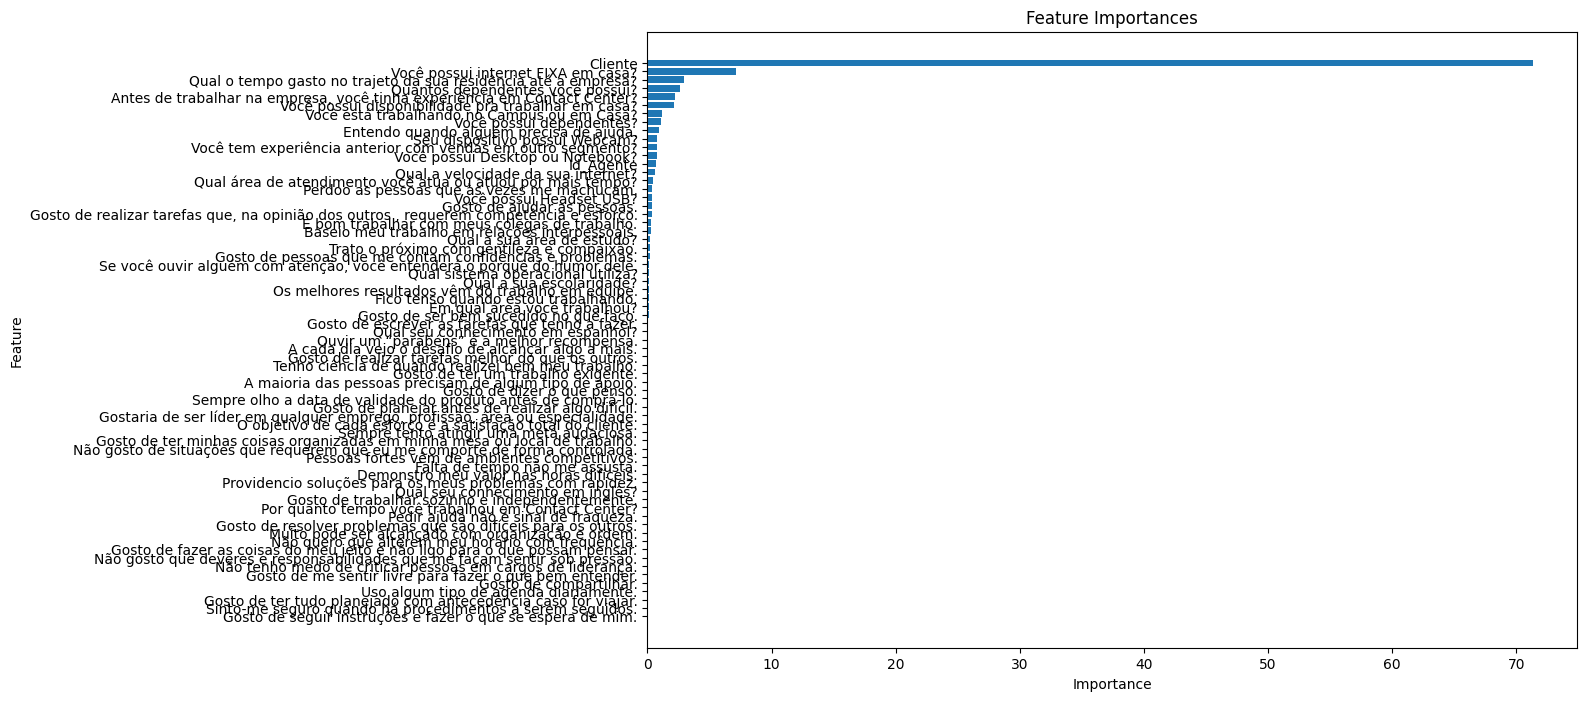

                                              Feature  Importance
1                                             Cliente   71.356588
20                 Você possui internet FIXA em casa?    7.172896
3   Qual o tempo gasto no trajeto da sua residênci...    2.933769
7                    Quantos dependentes você possui?    2.638038
10  Antes de trabalhar na empresa, você tinha expe...    2.251064
15  Você possui disponibilidade pra trabalhar em c...    2.150621
2         Você está trabalhando no Campus ou em Casa?    1.170864
6                            Você possui dependentes?    1.121636
55            Entendo quando alguém precisa de ajuda.    0.966618
18                     Seu dispositivo possui Webcam?    0.801049
14  Você tem experiência anterior com vendas em ou...    0.770153
16                   Você possui Desktop ou Notebook?    0.741224
0                                           Id_Agente    0.710032
21                 Qual a velocidade da sua internet?    0.613962
12  Qual á

In [ ]:
# Obtendo as importâncias das características
feature_importances = model_cb.get_feature_importance(Pool(X_train, label=y_train, cat_features=cat_features))
feature_names = X_train.columns

# Criando um DataFrame para visualizar as importâncias
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Ordenando as características por importância
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualizando as importâncias das características
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

# Exibindo as top 10 características mais importantes
top_features = feature_importance_df.head(15)
print(top_features)

* Interpretação dos Resultados

Cliente (55.67%):

A variável mais importante, indicando que o tipo de cliente atendido pelos agentes tem uma grande influência no desempenho deles. Pode refletir que diferentes perfis de clientes requerem diferentes habilidades e comportamentos dos agentes.
Disponibilidade para trabalhar em casa (4.57%):

A disponibilidade para trabalhar remotamente é significativa, sugerindo que agentes que podem trabalhar de casa talvez tenham melhores condições de trabalho ou um ambiente mais favorável ao desempenho.
Possuir dependentes (4.34%):

A presença de dependentes pode influenciar a responsabilidade e a organização dos agentes, afetando seu desempenho.
Experiência anterior com vendas (3.84%):

A experiência prévia em vendas pode dotar os agentes de habilidades valiosas para o atendimento ao cliente, contribuindo para um desempenho superior.
Trabalhar bem com colegas (2.70%):

A habilidade de trabalhar bem em equipe também é crucial, indicando que bons relacionamentos interpessoais são importantes para o sucesso.
Recomendações
Ajuste no Recrutamento:

Considere focar no histórico dos candidatos em relação ao tipo de cliente que atenderam previamente, disponibilidade para trabalho remoto, e experiência em vendas.
Ambiente de Trabalho:

Proporcione suporte para que mais agentes possam trabalhar de casa, se isso for viável e benéfico.
Treinamento Focado:

Desenvolva treinamentos específicos para melhorar a colaboração entre colegas e a gestão de responsabilidades pessoais e profissionais.
Avaliação Contínua:

Continue monitorando essas variáveis importantes e adapte as estratégias conforme necessário para manter e melhorar a performance dos agentes.

## SHAP

In [ ]:
#importando o SHAP
import shap

In [ ]:
#calcular valores SHAP
explainer = shap.TreeExplainer(model_cb)
shap_values = explainer.shap_values(X_test)


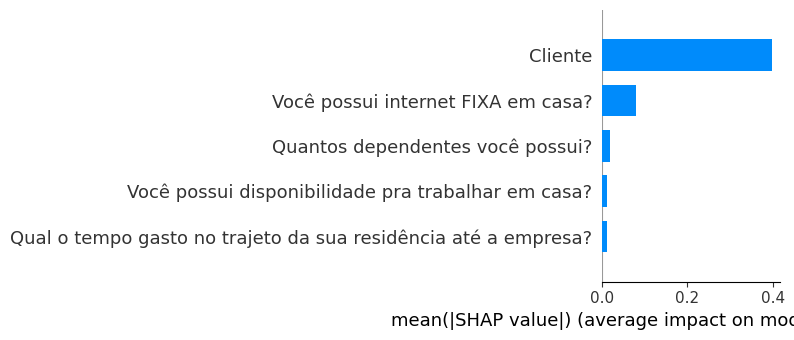

In [ ]:
# visualizar valores SHAP
# Sumário dos valores SHAP
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=5)


Esta visualização mostra a importância média das cinco principais características no modelo, baseando-se na magnitude dos valores SHAP.

* Cliente: Esta variável tem a maior influência no desempenho dos agentes.
* Você possui internet FIXA em casa?: Esta variável também tem um impacto significativo.
* Quantos dependentes você possui?: Esta variável tem uma influência menor, mas ainda relevante.
* Você possui disponibilidade pra trabalhar em casa?: Esta variável também contribui para a previsão.
* Qual o tempo gasto no trajeto da sua residência até a empresa?: Esta é a variável com a menor influência entre as cinco principais.

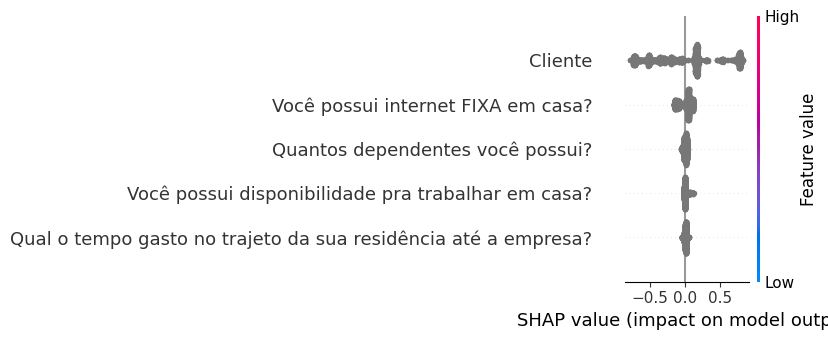

In [ ]:
# Plot das características mais importantes
shap.summary_plot(shap_values, X_test, max_display=5)

Esta visualização detalha a direção e a magnitude do impacto das cinco principais características em cada previsão individual:

* Cliente:
As diferentes categorias de clientes têm um impacto significativo e variado no modelo.
Os pontos dispersos mostram que há tanto contribuições positivas quanto negativas para as previsões, dependendo da categoria do cliente.

* Você possui internet FIXA em casa?:
Ter internet fixa parece ter um impacto positivo mais consistente nas previsões de bom desempenho, com alguns valores contribuindo positivamente e outros negativamente.

* Quantos dependentes você possui?:
O número de dependentes tem um impacto menor e mais concentrado, com alguns valores contribuindo positivamente.

* Você possui disponibilidade pra trabalhar em casa?:
A disponibilidade para trabalhar em casa tende a ter um impacto positivo nas previsões.

* Qual o tempo gasto no trajeto da sua residência até a empresa?:
O tempo de trajeto tem um impacto pequeno e concentrado, sem uma tendência clara para afetar negativamente ou positivamente.